### Strategy Design & Backtesting Performance

This notebook contains all the strategies class designed based on `Data Analysis.ipynb`.
+ Arbitrage Strategy
+ Overnight Strategy
+ Pricing Model Strategy
+ Intraday Strategy

In [1]:
import os
import copy
import pickle
import random
import pandas as pd
import numpy as np
import import_ipynb
from tqdm import tqdm
from collections import defaultdict

import seaborn as sns
from matplotlib import pyplot as plt 

plt.style.use('seaborn')
pd.set_option('display.max_columns',None)
pd.set_option('display.float_format', lambda x: '%.4f' % x)

In [2]:
# load backtesting file
%load_ext autoreload
%autoreload 2

import backtest_config
from Backtest import CbondBacktest

importing Jupyter notebook from Backtest.ipynb


In [3]:
# Strategy parent class
class Strategy:
    
    def __init__(self, CBT):
        self.CBT = CBT
        self.dataLoader()
        
    def dataLoader(self):
        self.cbond_info = self.CBT.cbond_info
        self.cbond_data = self.CBT.cbond_data_raw
        self.stock_data = self.CBT.stock_data_raw
        self.cbond_data['date'] = self.cbond_data['date'].astype('str').map(lambda x: x.replace('-', ''))
    
    
    # =============== Interaction with Backtest System =================
    def sendOrder(self, date, time='close'):
        pass
    
    def analysis(self):
        pass

#### 0. Random Strategy (for the purpose of testing)

In [4]:
class RandomStrategy(Strategy):
    '''
    Randomly buy 10 bonds and its stocks at open and close, 
    convert 0.1% bond at close,
    sell all at open
    '''
    def __init__(self, CBT, seed, num):
        Strategy.__init__(self, CBT)
        self.num = num
        np.random.seed(seed)
    
    # ================= Strategy ====================
    def randomsample(self, date, time):
        daily_data = self.cbond_data.loc[self.cbond_data['date']==date].copy()
        strategy_df = pd.DataFrame()

        if not daily_data.empty:
            strategy_df['bond_ticker'] = daily_data['bond_ticker']
            strategy_df['factor'] = np.random.rand(strategy_df.shape[0])
        
        strategy_df = self.calWeight(strategy_df)
        return strategy_df
    
    
    def calWeight(self, strategy_df):      
        strategy_df['abs_fac'] = np.abs(strategy_df['factor'])
        strategy_df = strategy_df.sort_values(by='factor', ascending=False).reset_index(drop=True)
        
        num = min(len(strategy_df), self.num)
        strategy_df = strategy_df.iloc[:num].copy()

        strategy_df['weight'] = strategy_df['abs_fac'] / strategy_df['abs_fac'].sum()
        strategy_df['weight'] = strategy_df['weight'] * np.sign(strategy_df['factor']) 
        long_cash = max(0, self.CBT.cap - self.CBT.getPortfolioLongCost())
#         print(long_cash)
        strategy_df['capital'] = strategy_df['weight'] * long_cash
        
        return strategy_df
    
    
    # =============== Interaction with Backtest System =================
    def sendOrder(self, date, time='close'):
        if time == 'open': # clear holdings at open
            self.CBT.clearHolding(date, time)
        
        # call signal generation function
        strategy_df = self.randomsample(date, time)

        # calculate capital & amount allocated to each asset
        for dic in strategy_df.to_dict(orient='records'):
            
            bond_ticker = dic['bond_ticker']
            capital = dic['capital']
            bond_price = self.CBT.getPrice(date, bond_ticker, asset_type='bond', time=time)
            bond_amount = int(capital / bond_price // self.CBT.min_share['bond'] * self.CBT.min_share['bond'])
            stock_ticker = self.CBT.getCbondStock(bond_ticker)
            stock_amount = self.CBT.getTransferAmount(date, bond_ticker, bond_amount, time) * -1
            stock_price = self.CBT.getPrice(date, stock_ticker, asset_type='stock', time=time)
            stock_amount = int(capital / stock_price // self.CBT.min_share['stock'] * self.CBT.min_share['stock']) * -1
            if (bond_amount != 0) & (stock_amount != 0):
                self.CBT.order(date, bond_ticker, bond_amount, asset_type='bond', time=time)
                self.CBT.order(date, stock_ticker, stock_amount, asset_type='stock', time=time)
            
        if time == 'close':
            for bond_ticker in list(self.CBT.portfolio['bond'].keys()):
                # convert 1% bond to stock
                transfer_amount = self.CBT.portfolio['bond'][bond_ticker]['amount'] // 1000
                transfer_amount = transfer_amount // 10 * 10
                if transfer_amount > 0:
                    self.CBT.transfer(date, bond_ticker, transfer_amount, time)

  0%|          | 4/886 [00:00<00:23, 37.74it/s]

== backtest init ==


100%|██████████| 886/886 [00:24<00:00, 36.20it/s]


,total_return,annual_return,annual_volatility,sharpe_ratio,win_rate,max_drawdown
pnl,-0.3231,-0.0912,0.1716,-0.7643,0.4695,-0.4161
pnl_open,0.6965,0.1965,0.0778,2.0110,0.5609,-0.0617
pnl_close,-1.0196,-0.2877,0.1517,-2.1609,0.4447,-1.0243
pnl_trade,-0.1192,-0.0336,0.1692,-0.4353,0.4831,-0.2940
pnl_trans,-0.2039,-0.0575,0.0009,-103.8063,0.0011,-0.2037
pnl_intra,-0.8156,-0.2301,0.1517,-1.7812,0.4549,-0.8245
pnl_ovnt,0.4925,0.1390,0.0778,1.2717,0.5339,-0.0877
pnl_hedge,-0.3144,-0.0887,0.1723,-0.7471,0.4695,-0.4076
net,-1.3729,-0.3874,0.1716,-2.4911,0.4300,-1.3647
net_hedge,-1.3643,-0.3849,0.1722,-2.4671,0.4300,-1.3562


,dates,trade_dates,order_sum,order_mean,cover_num,trade_win,conv_win,order_cost,refuse_rate,turnover,port_num,port_value,long_ratio
bond,886,1.0000,17749.0000,20.0327,325,0.4820,0.0038,1.9678,0.0089,245.9755,10.1524,0.9985,0.9994
stock,886,1.0000,17724.0000,20.0045,319,0.4913,0.0038,1.9634,0.0112,245.4229,10.1603,0.9987,0.0006
total,886,1.0000,35473.0000,40.0372,644,0.4866,0.0038,3.9312,0.0100,491.3984,20.3126,1.9972,0.5002


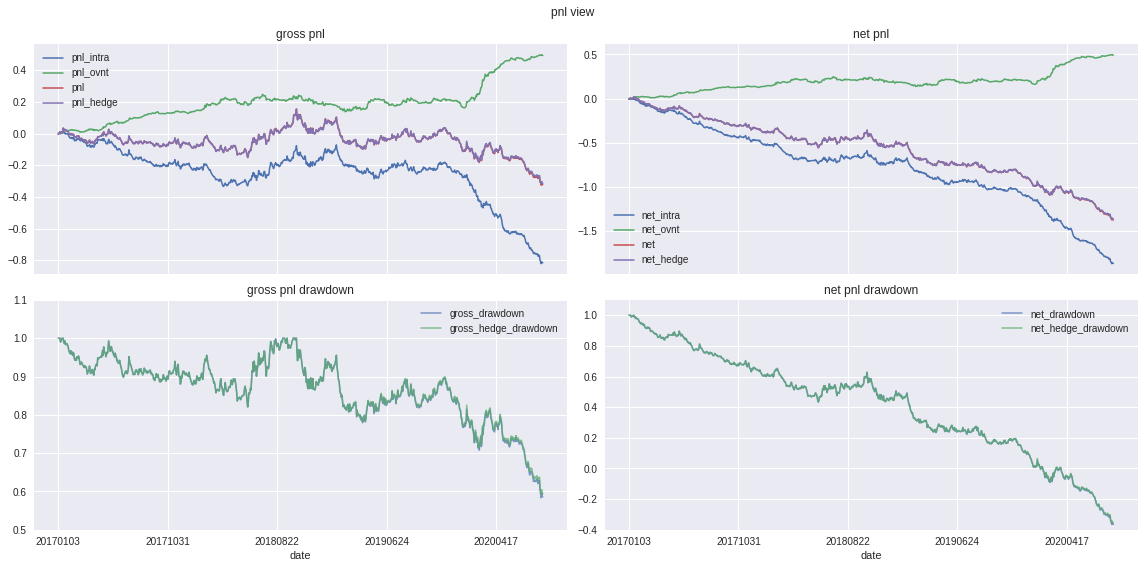

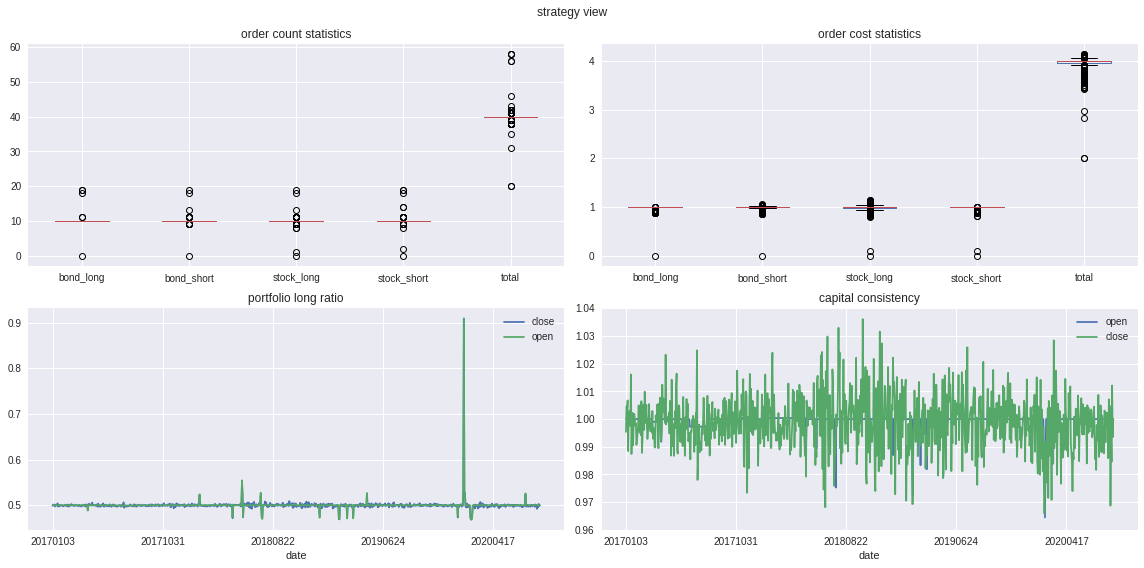

In [5]:
CBT = CbondBacktest(backtest_config)
strategy = RandomStrategy(CBT, seed=100, num=10)
CBT.pipeline(strategy)
CBT.analysis()

#### 1. Arbitrage Strategy (Negative Premium)

In [5]:
class ArbStrategy(Strategy):
    '''
    Long convertible bond and short stock at close if negative converting premium exists
    Convert bond to stock at close
    Profit is locked at the beginning 
    '''
    def __init__(self, CBT, premium=0, pool=None):
        Strategy.__init__(self, CBT)
        self.premium_data = pd.read_csv(os.path.join(self.CBT.data_path, 'neg_premium.csv'), index_col=False)
        self.premium_data['date'] = self.premium_data['date'].astype('str')
        self.premium_data['all'] = True
        
        self.premium = premium
        self.pool = pool if pool is not None else 'all'
        self.max_weight = 0.2
        
        self.value = {}
    
    # =============== Interaction with Backtest System =================
    def sendOrder(self, date, time='close'):
        if time == 'open': # clear holdings at open
            self.CBT.clearHolding(date, time)

        else:
            # signal
            data = self.premium_data[(self.premium_data['date'] == date) & 
                                     (self.premium_data['{}'.format(self.pool)]==True) &
                                     (self.premium_data['premium_close'] < self.premium) & 
                                     (self.premium_data['limit_sell_close']==False) & 
                                     (self.premium_data['is_unusual']==False)].copy()
            data_info = data.to_dict('records')
            num = len(data_info)
                
            if num == 0:
                return None
            
            # available cash
            long_cash = self.CBT.cap - self.CBT.getPortfolioLongCost()
            capital = min(long_cash / num, long_cash * self.max_weight)
            self.value[date] = defaultdict(int)
            
            # order
            for info in data_info:
                bond_ticker = info['bond_ticker']
                bond_price = self.CBT.getPrice(date, bond_ticker, asset_type='bond', time=time)
                bond_amount = int(capital / bond_price // self.CBT.min_share['bond'] * self.CBT.min_share['bond'])
                bond_mkt_value = self.CBT.getValue(date, bond_ticker, asset_type='bond', time=time)
                
                stock_ticker = info['stock_ticker']
                stock_amount = self.CBT.getTransferAmount(date, bond_ticker, bond_amount, time) * -1
                stock_mkt_value = self.CBT.getValue(date, stock_ticker, asset_type='stock', time=time)
                
                if (bond_amount != 0) & (stock_amount != 0):
                    self.CBT.order(date, bond_ticker, bond_amount, asset_type='bond', time=time)
                    self.CBT.order(date, stock_ticker, stock_amount, asset_type='stock', time=time)
                    self.value[date]['bond'] += bond_mkt_value
                    self.value[date]['stock'] += stock_mkt_value
                    self.value[date]['count'] += 1
        
        # convert convertible bond to stock
        if time == 'close':
            for bond_ticker in list(self.CBT.portfolio['bond'].keys()):
                self.CBT.transfer(date, bond_ticker, self.CBT.portfolio['bond'][bond_ticker]['amount'], time)
                
    # record market trading value
    def analysis(self):
        value_stat = pd.DataFrame(self.value).T
        res = pd.DataFrame([np.round((value_stat['bond'] / value_stat['count']).mean(), 4),
              np.round((value_stat['stock'] / value_stat['count']).mean(), 4)], 
                           columns=['Avg Trading Value'], index=['bond', 'stock'])
        return res

  1%|          | 10/886 [00:00<00:09, 95.50it/s]

== backtest init ==


100%|██████████| 886/886 [00:11<00:00, 80.15it/s]


,total_return,annual_return,annual_volatility,sharpe_ratio,win_rate,max_drawdown
pnl,2.3644,0.6672,0.0511,12.2808,0.9977,-0.0001
pnl_open,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000
pnl_close,2.3644,0.6672,0.0511,12.2808,0.9977,-0.0001
pnl_trade,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000
pnl_trans,2.3644,0.6672,0.0511,12.2808,0.9977,-0.0001
pnl_intra,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000
pnl_ovnt,2.3644,0.6672,0.0511,12.2808,0.9977,-0.0001
pnl_hedge,2.3644,0.6672,0.0511,12.2808,0.9977,-0.0001
net,2.1284,0.6006,0.0479,11.7077,0.9932,-0.0003
net_hedge,2.1284,0.6006,0.0479,11.7077,0.9932,-0.0003


,dates,trade_dates,order_sum,order_mean,cover_num,trade_win,conv_win,order_cost,refuse_rate,turnover,port_num,port_value,long_ratio
bond,886,0.6625,3473.0000,5.9165,156,0,0.9718,0.6667,0.0000,55.2165,0.0000,0.0000,0.5000
stock,886,0.6625,3473.0000,5.9165,153,0,0.9718,0.6708,0.0000,55.5500,0.0000,0.0000,0.5000
total,886,0.6625,6946.0000,11.8330,309,0,0.9718,1.3375,0.0000,110.7665,0.0000,0.0000,0.5000


,Avg Trading Value
bond,1.9053
stock,4.9980


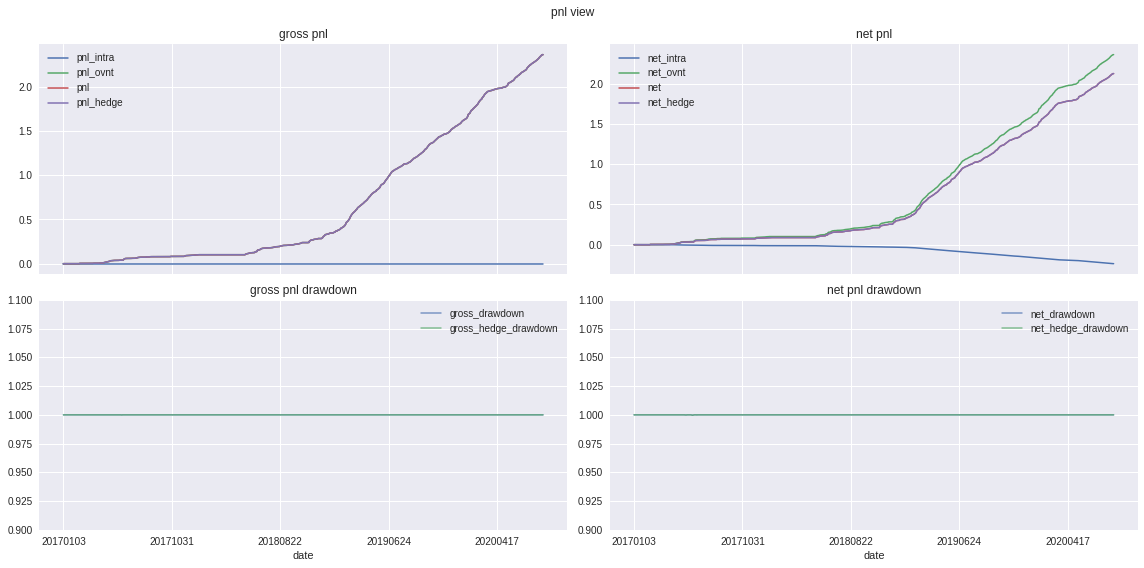

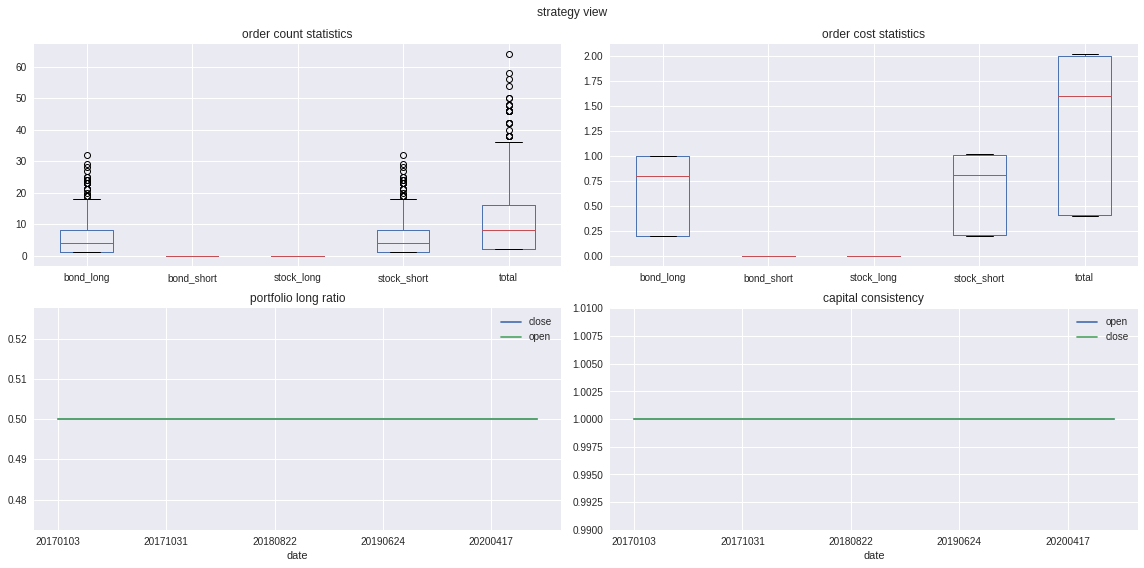

In [6]:
CBT = CbondBacktest(backtest_config)
strategy = ArbStrategy(CBT, premium=-0.001)
CBT.pipeline(strategy)
CBT.analysis(strategy)

**Arbitrage Strategy Threshold**

In [7]:
pools = ['all', 'top1500', 'CSI800', 'CSI300']
premium_list = np.linspace(0, -0.01, 11)
record  = {}

for pool in pools:
    comp = defaultdict(list)
    
    # run over premium threshold
    for premium in premium_list:
        CBT = CbondBacktest(backtest_config)
        strategy = ArbStrategy(CBT, premium=premium, pool=pool)
        CBT.pipeline(strategy)
        CBT.analysis(strategy, plot=False)

        pnl = CBT.result['pnl']
        daily = CBT.result['daily']
        res = CBT.result['strategy']
        
        # record backtesting statistics
        comp['premium'].append(premium)
        comp['trade_pct'].append(daily.loc['total', 'trade_dates'])
        comp['gross_pnl'].append(pnl.loc['pnl', 'annual_return'])
        comp['net_pnl'].append(pnl.loc['net', 'annual_return'])
        comp['net_hedge_pnl'].append(pnl.loc['net_hedge', 'annual_return'])
        comp['sharpe'].append(pnl.loc['net_hedge', 'sharpe_ratio'])
        comp['order_mean'].append(daily.loc['total', 'order_mean'])
        comp['order_cost'].append(daily.loc['total', 'order_cost'])
        comp['turnover'].append(daily.loc['total', 'turnover'])
    
    comp = pd.DataFrame(comp)
    record[pool] = comp

== backtest init ==


100%|██████████| 886/886 [00:11<00:00, 80.24it/s]


== backtest init ==


100%|██████████| 886/886 [00:11<00:00, 80.01it/s]


== backtest init ==


100%|██████████| 886/886 [00:11<00:00, 80.49it/s]


== backtest init ==


100%|██████████| 886/886 [00:10<00:00, 82.67it/s]


== backtest init ==


100%|██████████| 886/886 [00:10<00:00, 84.47it/s]


== backtest init ==


100%|██████████| 886/886 [00:10<00:00, 88.32it/s]


== backtest init ==


100%|██████████| 886/886 [00:09<00:00, 90.32it/s]


== backtest init ==


100%|██████████| 886/886 [00:10<00:00, 88.03it/s]


== backtest init ==


100%|██████████| 886/886 [00:10<00:00, 87.39it/s]


== backtest init ==


100%|██████████| 886/886 [00:09<00:00, 90.36it/s]


== backtest init ==


100%|██████████| 886/886 [00:09<00:00, 90.57it/s]


== backtest init ==


100%|██████████| 886/886 [00:11<00:00, 79.98it/s]


== backtest init ==


100%|██████████| 886/886 [00:10<00:00, 80.85it/s]


== backtest init ==


100%|██████████| 886/886 [00:10<00:00, 82.07it/s]


== backtest init ==


100%|██████████| 886/886 [00:10<00:00, 83.42it/s]


== backtest init ==


100%|██████████| 886/886 [00:10<00:00, 86.20it/s]


== backtest init ==


100%|██████████| 886/886 [00:10<00:00, 87.42it/s]


== backtest init ==


100%|██████████| 886/886 [00:10<00:00, 87.56it/s]


== backtest init ==


100%|██████████| 886/886 [00:10<00:00, 87.53it/s]


== backtest init ==


100%|██████████| 886/886 [00:09<00:00, 89.80it/s]


== backtest init ==


100%|██████████| 886/886 [00:09<00:00, 89.69it/s]


== backtest init ==


100%|██████████| 886/886 [00:09<00:00, 91.58it/s]


== backtest init ==


100%|██████████| 886/886 [00:10<00:00, 85.15it/s]


== backtest init ==


100%|██████████| 886/886 [00:10<00:00, 85.40it/s]


== backtest init ==


100%|██████████| 886/886 [00:10<00:00, 87.80it/s]


== backtest init ==


100%|██████████| 886/886 [00:10<00:00, 88.03it/s]


== backtest init ==


100%|██████████| 886/886 [00:09<00:00, 89.08it/s]


== backtest init ==


100%|██████████| 886/886 [00:09<00:00, 89.47it/s]


== backtest init ==


100%|██████████| 886/886 [00:09<00:00, 90.44it/s]


== backtest init ==


100%|██████████| 886/886 [00:09<00:00, 90.53it/s]


== backtest init ==


100%|██████████| 886/886 [00:09<00:00, 91.17it/s]


== backtest init ==


100%|██████████| 886/886 [00:09<00:00, 90.40it/s]


== backtest init ==


100%|██████████| 886/886 [00:09<00:00, 92.41it/s]


== backtest init ==


100%|██████████| 886/886 [00:09<00:00, 90.01it/s]


== backtest init ==


100%|██████████| 886/886 [00:09<00:00, 90.52it/s]


== backtest init ==


100%|██████████| 886/886 [00:09<00:00, 90.36it/s]


== backtest init ==


100%|██████████| 886/886 [00:09<00:00, 91.35it/s]


== backtest init ==


100%|██████████| 886/886 [00:09<00:00, 91.70it/s]


== backtest init ==


100%|██████████| 886/886 [00:09<00:00, 92.40it/s]


== backtest init ==


100%|██████████| 886/886 [00:09<00:00, 92.99it/s]


== backtest init ==


100%|██████████| 886/886 [00:09<00:00, 94.06it/s]


== backtest init ==


100%|██████████| 886/886 [00:09<00:00, 95.59it/s]


== backtest init ==


100%|██████████| 886/886 [00:09<00:00, 96.08it/s]


== backtest init ==


100%|██████████| 886/886 [00:09<00:00, 95.16it/s]


In [8]:
for pool, comp in record.items():
    print(pool)
    display(comp)

all


,premium,trade_pct,gross_pnl,net_pnl,net_hedge_pnl,sharpe,order_mean,order_cost,turnover
0,0.0000,0.6840,0.6287,0.5597,0.5597,11.4450,12.5644,1.3435,114.8662
1,-0.0010,0.6625,0.6672,0.6006,0.6006,11.7077,11.8330,1.3375,110.7665
2,-0.0020,0.6264,0.7072,0.6455,0.6455,11.6698,10.7964,1.3104,102.6047
3,-0.0030,0.5756,0.7334,0.6790,0.6790,11.2675,9.6157,1.2560,90.3728
4,-0.0040,0.5350,0.7401,0.6919,0.6919,10.7731,8.5274,1.1970,80.0497
5,-0.0050,0.4876,0.7228,0.6816,0.6816,10.0151,7.5602,1.1216,68.3603
6,-0.0060,0.4549,0.7025,0.6665,0.6665,9.4204,6.6700,1.0513,59.7728
7,-0.0070,0.4176,0.6695,0.6384,0.6384,8.8254,6.0000,0.9891,51.6304
8,-0.0080,0.3691,0.6249,0.5987,0.5987,8.1086,5.5046,0.9401,43.3692
9,-0.0090,0.3341,0.5842,0.5619,0.5619,7.5222,5.0068,0.8880,37.0852


top1500


,premium,trade_pct,gross_pnl,net_pnl,net_hedge_pnl,sharpe,order_mean,order_cost,turnover
0,0.0000,0.6682,0.5552,0.4907,0.4907,10.9829,9.9797,1.2857,107.3819
1,-0.0010,0.6445,0.5821,0.5207,0.5207,11.2297,9.4116,1.2680,102.1477
2,-0.0020,0.6084,0.6067,0.5508,0.5508,11.1286,8.5417,1.2217,92.9057
3,-0.0030,0.5497,0.6171,0.5688,0.5688,10.5977,7.6345,1.1675,80.2143
4,-0.0040,0.5068,0.6104,0.5684,0.5684,10.0666,6.7350,1.1032,69.8844
5,-0.0050,0.4481,0.5768,0.5419,0.5419,9.2620,6.0957,1.0348,57.9608
6,-0.0060,0.4131,0.5451,0.5154,0.5154,8.6273,5.4044,0.9572,49.4240
7,-0.0070,0.3691,0.5057,0.4808,0.4808,7.9198,4.9113,0.8972,41.3911
8,-0.0080,0.3228,0.4570,0.4367,0.4367,7.1618,4.4476,0.8322,33.5793
9,-0.0090,0.2833,0.4129,0.3962,0.3962,6.5759,4.1195,0.7835,27.7449


CSI800


,premium,trade_pct,gross_pnl,net_pnl,net_hedge_pnl,sharpe,order_mean,order_cost,turnover
0,0.0000,0.5192,0.3398,0.2975,0.2975,7.4688,6.1435,1.0826,70.2574
1,-0.0010,0.4989,0.3470,0.3077,0.3077,7.5878,5.8552,1.0480,65.3515
2,-0.0020,0.4616,0.3440,0.3110,0.3110,7.4567,5.2518,0.9516,54.9102
3,-0.0030,0.4086,0.3283,0.3020,0.3020,6.9866,4.6409,0.8540,43.6162
4,-0.0040,0.3612,0.3096,0.2883,0.2883,6.4915,4.1688,0.7846,35.4243
5,-0.0050,0.3059,0.2829,0.2662,0.2662,5.8104,3.8450,0.7284,27.8492
6,-0.0060,0.2720,0.2639,0.2500,0.2500,5.3443,3.5021,0.6810,23.1559
7,-0.0070,0.2348,0.2406,0.2291,0.2291,4.8212,3.3077,0.6483,19.0248
8,-0.0080,0.1885,0.2143,0.2051,0.2051,4.3278,3.2814,0.6464,15.2307
9,-0.0090,0.1580,0.1944,0.1867,0.1867,3.9335,3.2286,0.6420,12.6814


CSI300


,premium,trade_pct,gross_pnl,net_pnl,net_hedge_pnl,sharpe,order_mean,order_cost,turnover
0,0.0000,0.3567,0.1310,0.1127,0.1127,3.8754,3.5190,0.6837,30.4820
1,-0.0010,0.3386,0.1333,0.1164,0.1164,3.9613,3.3867,0.6629,28.0566
2,-0.0020,0.2822,0.1300,0.1170,0.1170,3.8735,3.1120,0.6114,21.5653
3,-0.0030,0.2111,0.1209,0.1114,0.1114,3.5171,3.0053,0.5991,15.8048
4,-0.0040,0.1840,0.1130,0.1053,0.1053,3.2379,2.7853,0.5570,12.8100
5,-0.0050,0.1524,0.1035,0.0973,0.0973,2.8797,2.7259,0.5449,10.3787
6,-0.0060,0.1287,0.0937,0.0887,0.0887,2.5160,2.5614,0.5152,8.2858
7,-0.0070,0.1106,0.0853,0.0812,0.0812,2.2010,2.4898,0.5010,6.9273
8,-0.0080,0.0858,0.0749,0.0717,0.0717,1.7454,2.5000,0.5035,5.3984
9,-0.0090,0.0745,0.0680,0.0653,0.0653,1.4432,2.4242,0.4885,4.5485


#### 2. Overnight Strategy

In [6]:
class OvntStrategy(Strategy):
    '''
    buy convertible bond based on ovnt factors value at close
    sell all at next day open
    '''
    
    def __init__(self, CBT, num=20, thr=0.02, pool='all'):
        Strategy.__init__(self, CBT)
        self.ovnt_data = pd.read_csv(os.path.join(self.CBT.data_path, 'ovnt_arb.csv'), index_col=False)
        self.ovnt_data['date'] = self.ovnt_data['date'].astype('str')
        self.ovnt_data['all'] = True
        
        self.pool = pool if pool is not None else 'all'
        self.max_weight = 0.2
        self.num = num
        self.score_thr = thr
    
    
    # =============== Interaction with Backtest System =================
    def sendOrder(self, date, time='close'):
        if time == 'open': # clear holdings at open
            self.CBT.clearHolding(date, time)
        
        else:
            # signal
            data = self.ovnt_data[(self.ovnt_data['date'] == date) &
                                 (self.ovnt_data['{}'.format(self.pool)]==True)].copy()
            data = data[(data['ovnt_fac'] >= self.score_thr)]
            num = len(data)
            if num == 0:
                return None
            
            # signal numbers limit
            data.sort_values(by='ovnt_fac', ascending=False)
            data = data.iloc[:self.num]
            
            # available cash
            long_cash = self.CBT.cap - self.CBT.getPortfolioLongCost()
            data['weight'] = np.minimum(data['ovnt_fac'] / data['ovnt_fac'].sum(), 0.2)
            data['capital'] = data['weight'] * long_cash
            
            data_info = data.to_dict('records')
            
            # order
            for info in data_info:
                bond_ticker = info['bond_ticker']
                bond_price = self.CBT.getPrice(date, bond_ticker, asset_type='bond', time=time)
                bond_capital = info['capital']
                bond_amount = int(bond_capital / bond_price // self.CBT.min_share['bond'] * self.CBT.min_share['bond'])
                if bond_amount != 0:
                    self.CBT.order(date, bond_ticker, bond_amount, asset_type='bond', time=time)
#                 print('order {} {} {}'.format(date, bond_ticker, stock_ticker))

== backtest init ==


100%|██████████| 886/886 [00:11<00:00, 74.09it/s]


,total_return,annual_return,annual_volatility,sharpe_ratio,win_rate,max_drawdown
pnl,1.6632,0.4693,0.1316,3.2624,0.7754,-0.0524
pnl_open,1.6632,0.4693,0.1316,3.2624,0.7754,-0.0524
pnl_close,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000
pnl_trade,1.6632,0.4693,0.1316,3.2624,0.7754,-0.0524
pnl_trans,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000
pnl_intra,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000
pnl_ovnt,1.6632,0.4693,0.1316,3.2624,0.7754,-0.0524
pnl_hedge,1.3257,0.3741,0.0932,3.5840,0.8002,-0.0403
net,1.5711,0.4433,0.1313,3.0715,0.7325,-0.0547
net_hedge,1.2335,0.3481,0.0929,3.3152,0.7540,-0.0419


,dates,trade_dates,order_sum,order_mean,cover_num,trade_win,conv_win,order_cost,refuse_rate,turnover,port_num,port_value,long_ratio
bond,886,0.7381,11042.0000,16.8838,174,0.5885,0,1.4096,0.0006,130.0590,3.1236,0.2602,0.6783
stock,886,0.7381,0.0000,0.0000,0,0.0000,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.5000
total,886,0.7381,11042.0000,16.8838,174,0.5885,0,1.4096,0.0006,130.0590,3.1236,0.2602,0.6783


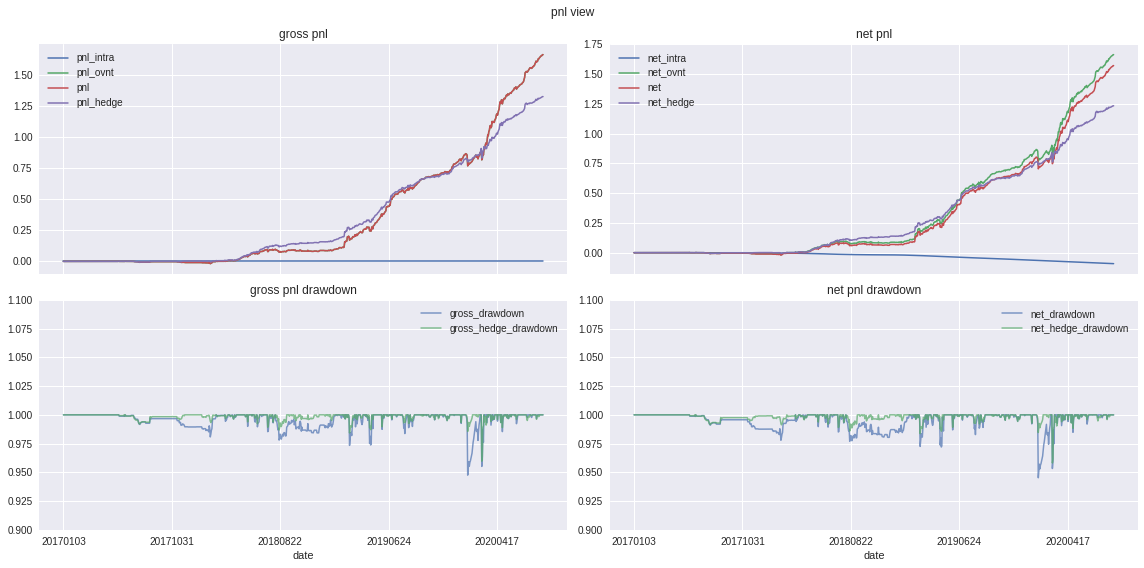

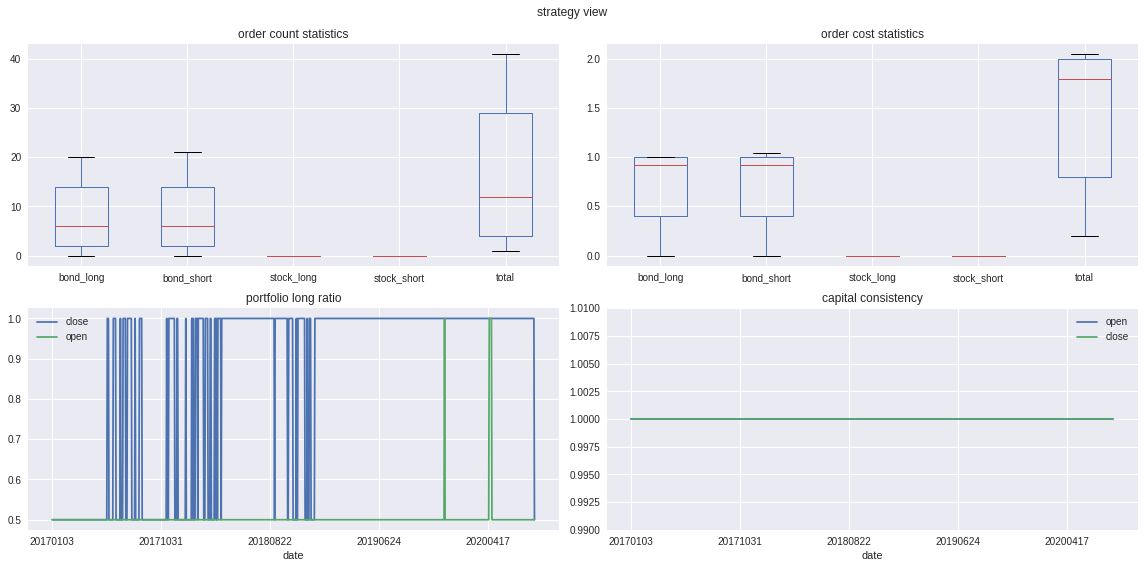

In [11]:
CBT = CbondBacktest(backtest_config)
strategy = OvntStrategy(CBT, num=20, thr=0.02, pool='top1500')
CBT.pipeline(strategy)
CBT.analysis()

#### 3. Consecutive Up Strategy (连续涨停)

In [7]:
class UpStrategy(Strategy):
    '''
    buy convertible bond based on up signal at close
    sell all at next day open
    '''
    def __init__(self, CBT, num=10, keep=[1], pool='all'):
        Strategy.__init__(self, CBT)
        self.ovnt_data = pd.read_csv(os.path.join(self.CBT.data_path, 'ovnt_arb.csv'), index_col=False)
        self.ovnt_data['date'] = self.ovnt_data['date'].astype('str')
        self.ovnt_data['all'] = True
        
        self.pool = pool if pool is not None else 'all'
        self.max_weight = 0.2
        self.num = num
        self.keep = keep
        
        self.count = 0
    
    
    # =============== Interaction with Backtest System =================
    def sendOrder(self, date, time='close'):
        if time == 'open': # clear holdings at open
            self.CBT.clearHolding(date, time)
        
        else:
            # signal
            data = self.ovnt_data[(self.ovnt_data['date'] == date) &
                                 (self.ovnt_data['{}'.format(self.pool)]==True)].copy()
            data = data[data['up'].isin(self.keep)].copy()
            data['up'] = np.sqrt(5 - data['up'])
            num = len(data)
            if num == 0:
                return None
            
            data.sort_values(by='up', ascending=False)
            data = data.iloc[:self.num]
            
            # available cash
            long_cash = self.CBT.cap - self.CBT.getPortfolioLongCost()
            data['weight'] = np.minimum(data['up'] / data['up'].sum(), 0.2)
            data['capital'] = data['weight'] * long_cash
            
            data_info = data.to_dict('records')
            
            # order
            for info in data_info:
                bond_ticker = info['bond_ticker']
                bond_price = self.CBT.getPrice(date, bond_ticker, asset_type='bond', time=time)
                bond_capital = info['capital']
                bond_amount = int(bond_capital / bond_price // self.CBT.min_share['bond'] * self.CBT.min_share['bond'])
                if bond_amount != 0:
                    self.CBT.order(date, bond_ticker, bond_amount, asset_type='bond', time=time)
                    self.count += 1

up limit in stock market, then buy convertible bond

== backtest init ==


100%|██████████| 886/886 [00:10<00:00, 82.14it/s]


,total_return,annual_return,annual_volatility,sharpe_ratio,win_rate,max_drawdown
pnl,0.5721,0.1614,0.0919,1.3208,0.8860,-0.0596
pnl_open,0.5721,0.1614,0.0919,1.3208,0.8860,-0.0596
pnl_close,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000
pnl_trade,0.5721,0.1614,0.0919,1.3208,0.8860,-0.0596
pnl_trans,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000
pnl_intra,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000
pnl_ovnt,0.5721,0.1614,0.0919,1.3208,0.8860,-0.0596
pnl_hedge,0.4295,0.1212,0.0814,0.9981,0.8837,-0.0550
net,0.5492,0.1550,0.0918,1.2519,0.7494,-0.0603
net_hedge,0.4066,0.1147,0.0813,0.9196,0.7562,-0.0557


,dates,trade_dates,order_sum,order_mean,cover_num,trade_win,conv_win,order_cost,refuse_rate,turnover,port_num,port_value,long_ratio
bond,886,0.4391,1226.0000,3.1517,169,0.5808,0,0.5885,0.0000,32.3003,0.3459,0.0644,0.5784
stock,886,0.4391,0.0000,0.0000,0,0.0000,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.5000
total,886,0.4391,1226.0000,3.1517,169,0.5808,0,0.5885,0.0000,32.3003,0.3459,0.0644,0.5784


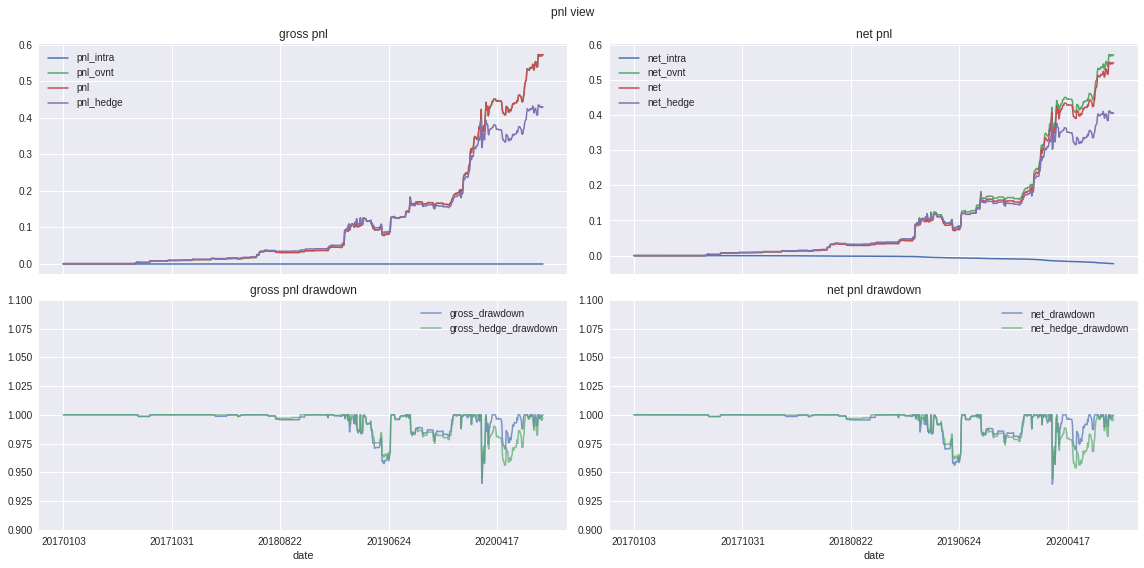

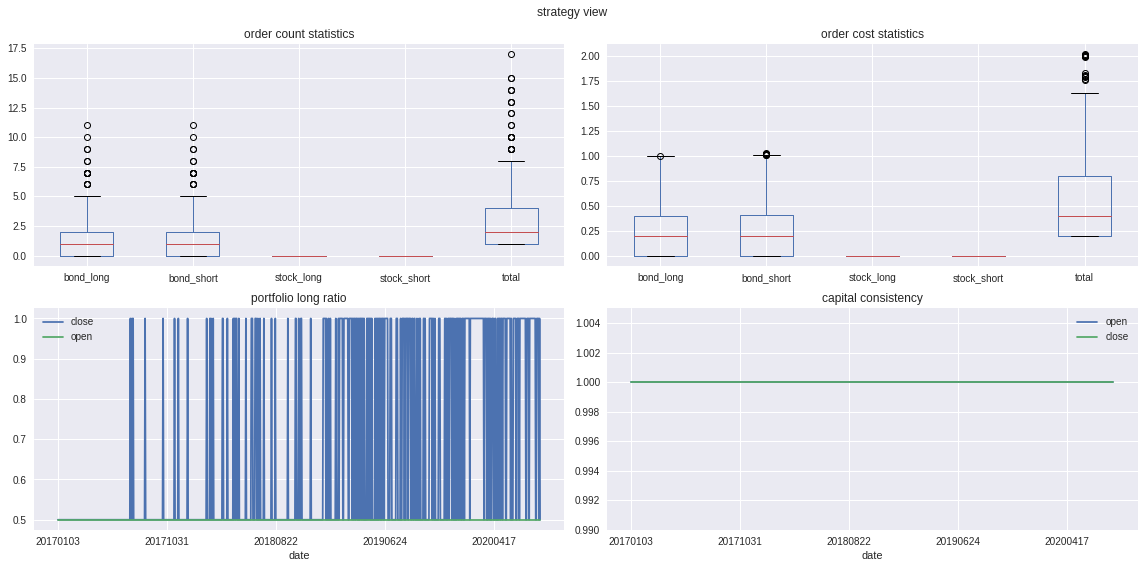

In [13]:
CBT = CbondBacktest(backtest_config)
strategy = UpStrategy(CBT, num=20, keep=[1, 2, 3, 4], pool='top1500')
CBT.pipeline(strategy)
CBT.analysis()

first up limit in stock market, then buy convertible bond

== backtest init ==


100%|██████████| 886/886 [00:10<00:00, 82.48it/s]


,total_return,annual_return,annual_volatility,sharpe_ratio,win_rate,max_drawdown
pnl,0.5140,0.1450,0.0700,1.5007,0.8883,-0.0376
pnl_open,0.5140,0.1450,0.0700,1.5007,0.8883,-0.0376
pnl_close,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000
pnl_trade,0.5140,0.1450,0.0700,1.5007,0.8883,-0.0376
pnl_trans,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000
pnl_intra,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000
pnl_ovnt,0.5140,0.1450,0.0700,1.5007,0.8883,-0.0376
pnl_hedge,0.3772,0.1064,0.0607,1.0937,0.8860,-0.0411
net,0.4939,0.1394,0.0699,1.4225,0.7381,-0.0388
net_hedge,0.3571,0.1008,0.0606,1.0023,0.7427,-0.0427


,dates,trade_dates,order_sum,order_mean,cover_num,trade_win,conv_win,order_cost,refuse_rate,turnover,port_num,port_value,long_ratio
bond,886,0.4300,1054.0000,2.7664,169,0.5939,0,0.5263,0.0000,28.2881,0.2974,0.0564,0.5728
stock,886,0.4300,0.0000,0.0000,0,0.0000,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.5000
total,886,0.4300,1054.0000,2.7664,169,0.5939,0,0.5263,0.0000,28.2881,0.2974,0.0564,0.5728


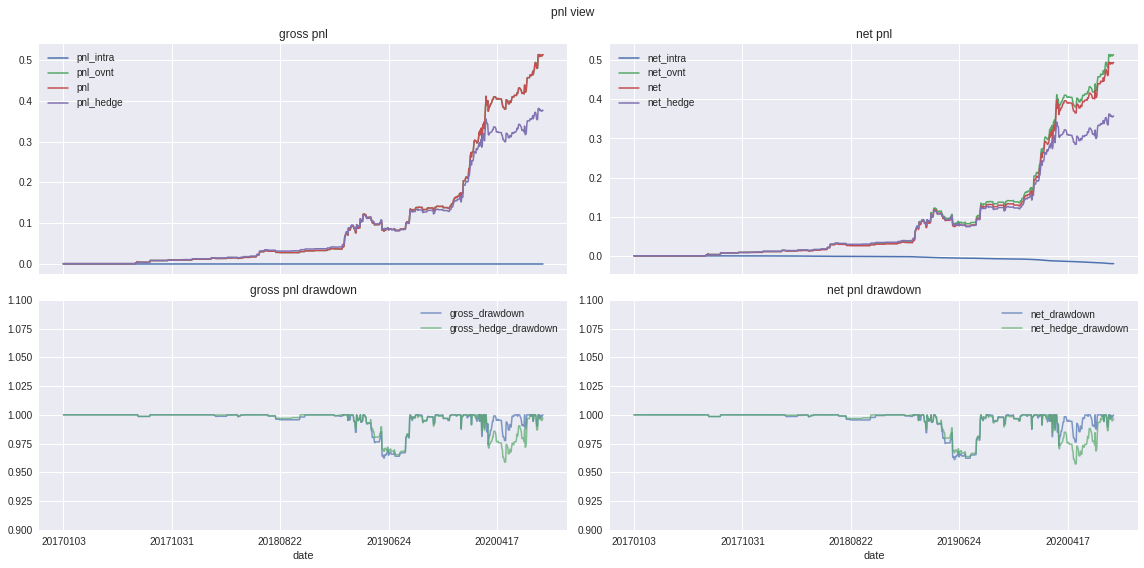

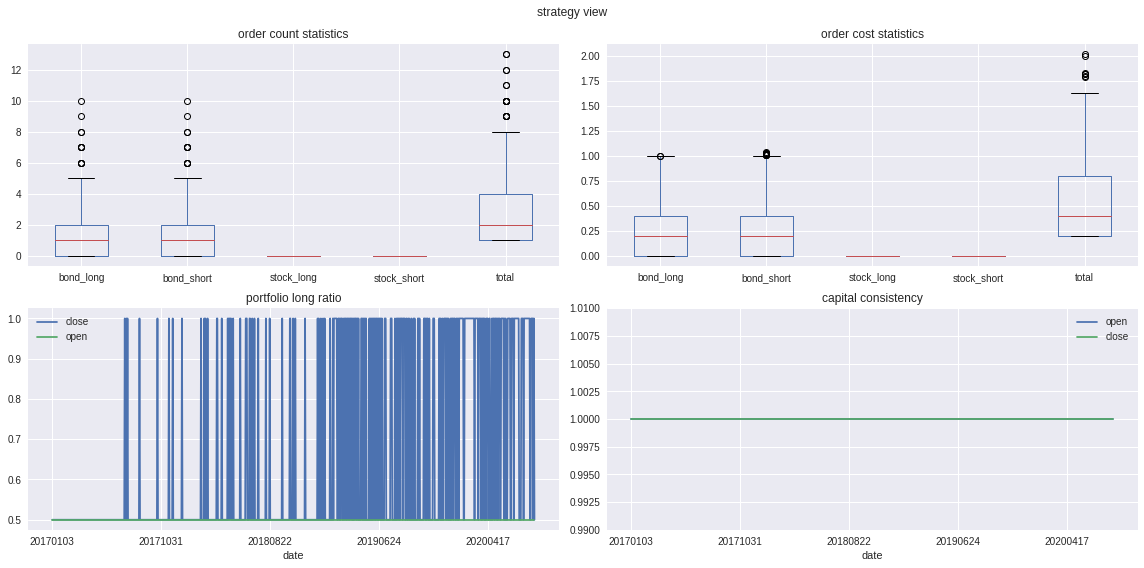

In [14]:
CBT = CbondBacktest(backtest_config)
strategy = UpStrategy(CBT, num=20, keep=[1], pool='top1500')
CBT.pipeline(strategy)
CBT.analysis()

#### 4. Ovnt & Up Strategy

In [8]:
class OvntUpStrategy(Strategy):
    '''
    buy convertible bond based on ovnt factors & up factors value at close
    sell all at open
    '''
    def __init__(self, CBT, num=10, thr=0.03, beta=1.5, pool='all'):
        Strategy.__init__(self, CBT)
        self.ovnt_data = pd.read_csv(os.path.join(self.CBT.data_path, 'ovnt_arb.csv'), index_col=False)
        self.ovnt_data['date'] = self.ovnt_data['date'].astype('str')
        self.ovnt_data['all'] = True
        
        self.pool = pool if pool is not None else 'all'
        self.max_weight = 0.2
        self.num = num
        self.score_thr = thr
        self.beta = beta
    
    
    # =============== Interaction with Backtest System =================
    def sendOrder(self, date, time='close'):
        if time == 'open': # clear holdings at open
            self.CBT.clearHolding(date, time)
        
        else:
            data = self.ovnt_data[(self.ovnt_data['date'] == date) &
                                 (self.ovnt_data['{}'.format(self.pool)]==True)].copy()
            score = data[data['score'] >= self.score_thr].copy()
            score['up'] = np.where(score['up'] > 0, 5 - score['up'], 0)
            score['score'] = score['score'] * (1 + (self.beta - 1) / 2 * np.sqrt(score['up']))
            
            if len(score) == 0:
                return None
            
            score.sort_values(by='score', ascending=False)
            score = score.iloc[:self.num]
            
            long_cash = self.CBT.cap - self.CBT.getPortfolioLongCost()
            score['weight'] = np.minimum(score['score'] / score['score'].sum(), 0.2)
            score['capital'] = score['weight'] * long_cash
            
            data_info = score.to_dict('records')
            
            for info in data_info:
                bond_ticker = info['bond_ticker']
                bond_price = self.CBT.getPrice(date, bond_ticker, asset_type='bond', time=time)
                bond_capital = info['capital']
                bond_amount = int(bond_capital / bond_price // self.CBT.min_share['bond'] * self.CBT.min_share['bond'])
                if bond_amount != 0:
                    self.CBT.order(date, bond_ticker, bond_amount, asset_type='bond', time=time)
#                 print('order {} {} {}'.format(date, bond_ticker, stock_ticker))

== backtest init ==


100%|██████████| 886/886 [00:12<00:00, 72.56it/s]


,total_return,annual_return,annual_volatility,sharpe_ratio,win_rate,max_drawdown
pnl,1.5640,0.4413,0.1355,2.9628,0.7709,-0.0533
pnl_open,1.5640,0.4413,0.1355,2.9628,0.7709,-0.0533
pnl_close,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000
pnl_trade,1.5640,0.4413,0.1355,2.9628,0.7709,-0.0533
pnl_trans,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000
pnl_intra,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000
pnl_ovnt,1.5640,0.4413,0.1355,2.9628,0.7709,-0.0533
pnl_hedge,1.2404,0.3500,0.1013,3.0589,0.7743,-0.0449
net,1.4841,0.4188,0.1352,2.8017,0.6569,-0.0554
net_hedge,1.1604,0.3274,0.1011,2.8433,0.6761,-0.0465


,dates,trade_dates,order_sum,order_mean,cover_num,trade_win,conv_win,order_cost,refuse_rate,turnover,port_num,port_value,long_ratio
bond,886,0.7788,8792.0000,12.7420,219,0.5660,0,1.1591,0.0005,112.8340,2.4853,0.2260,0.6735
stock,886,0.7788,0.0000,0.0000,0,0.0000,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.5000
total,886,0.7788,8792.0000,12.7420,219,0.5660,0,1.1591,0.0005,112.8340,2.4853,0.2260,0.6735


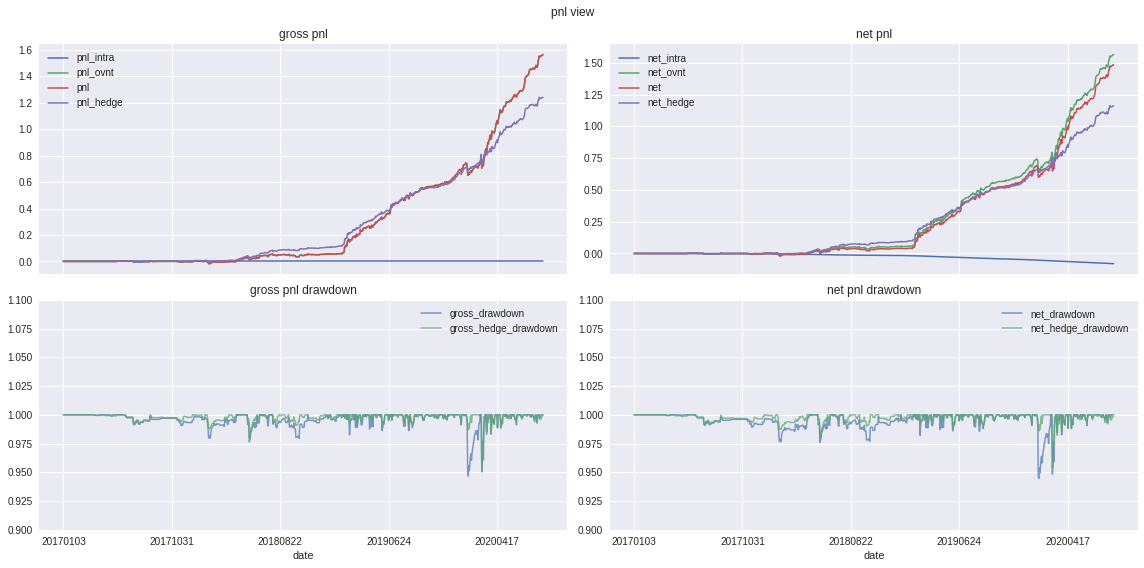

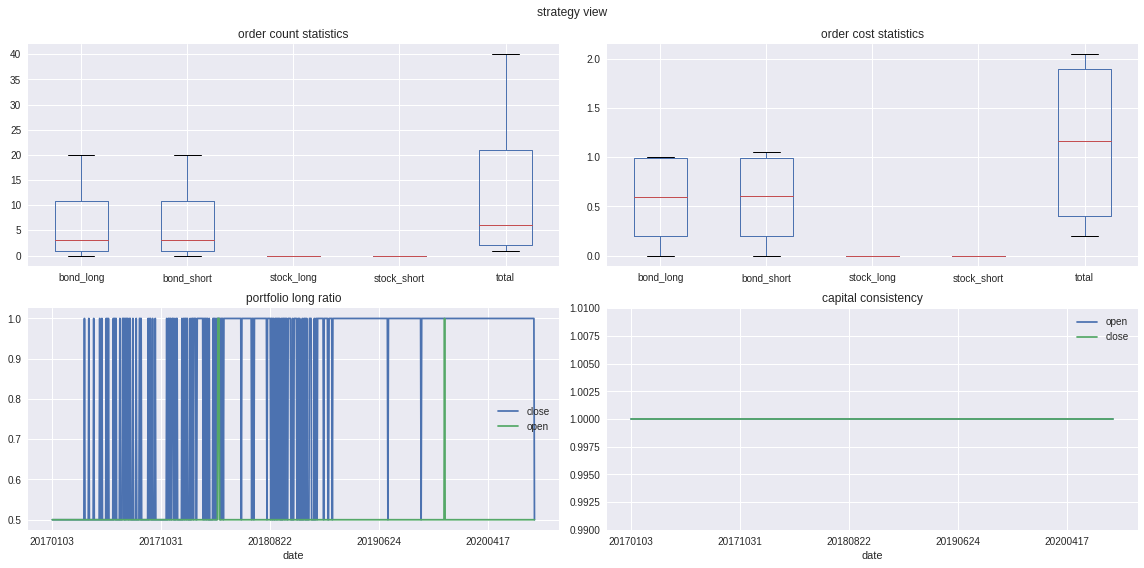

In [16]:
CBT = CbondBacktest(backtest_config)
strategy = OvntUpStrategy(CBT, num=20, thr=0.03, beta=1.1, pool='top1500')
CBT.pipeline(strategy)
CBT.analysis()

#### 5. Ovnt ML Strategy

In [9]:
class OvntMLStrategy(Strategy):
    '''
    buy convertible bond based on ML model ovnt factors at close
    sell all at open
    '''
    
    def __init__(self, CBT, model, pool='all'):
        Strategy.__init__(self, CBT)
        self.ovnt_data = pd.read_csv(os.path.join(self.CBT.data_path, 'ovnt_ml.csv'), index_col=False)
        self.ovnt_data['date'] = self.ovnt_data['date'].astype('str')
        self.ovnt_data['all'] = True
        
        self.pool = pool if pool is not None else 'all'
        self.max_weight = 0.2
        self.model = model
        assert(self.model in self.ovnt_data.columns)
        
        self.value = {}
    
    # =============== Interaction with Backtest System =================
    def sendOrder(self, date, time='close'):
        if time == 'open': # clear holdings at open
            self.CBT.clearHolding(date, time)
        
        else:
            data = self.ovnt_data[(self.ovnt_data['date'] == date) &
                                 (self.ovnt_data['{}'.format(self.pool)]==True) &
                                 (self.ovnt_data[self.model]==1)].copy()
            num = len(data)
            if num == 0:
                return None
            
            long_cash = self.CBT.cap - self.CBT.getPortfolioLongCost()
            data['weight'] = np.minimum(1 / num, 0.2)
            data['capital'] = data['weight'] * long_cash
            
            data_info = data.to_dict('records')
            self.value[date] = defaultdict(int)
            
            for info in data_info:
                bond_ticker = info['bond_ticker']
                bond_price = self.CBT.getPrice(date, bond_ticker, asset_type='bond', time=time)
                bond_capital = info['capital']
                bond_amount = int(bond_capital / bond_price // self.CBT.min_share['bond'] * self.CBT.min_share['bond'])
                bond_mkt_value = self.CBT.getValue(date, bond_ticker, asset_type='bond', time=time)
                
                if bond_amount != 0:
                    self.CBT.order(date, bond_ticker, bond_amount, asset_type='bond', time=time)
                    self.value[date]['bond'] += bond_mkt_value
                    self.value[date]['stock'] += 0
                    self.value[date]['count'] += 1
#                 print('order {} {} {}'.format(date, bond_ticker, stock_ticker))
        
    def analysis(self):
        value_stat = pd.DataFrame(self.value).T
        res = pd.DataFrame([np.round((value_stat['bond'] / value_stat['count']).mean(), 4),
              np.round((value_stat['stock'] / value_stat['count']).mean(), 4)], 
                           columns=['Avg Trading Value'], index=['bond', 'stock'])
        return res

In [18]:
# run over all ML models and present comparison
def record(comp, CBT, strategy):
    '''
    record backtesting performance statistics
    '''
    pnl = CBT.result['pnl']
    daily = CBT.result['daily']

    comp['model'].append(strategy)
    comp['trade_pct'].append(daily.loc['total', 'trade_dates'])
    comp['gross_pnl'].append(pnl.loc['pnl', 'annual_return'])
    comp['net_pnl'].append(pnl.loc['net', 'annual_return'])
    comp['net_hedge_pnl'].append(pnl.loc['net_hedge', 'annual_return'])
    comp['sharpe'].append(pnl.loc['net_hedge', 'sharpe_ratio'])
    comp['maxdrawdown'].append(pnl.loc['net_hedge', 'max_drawdown'])
    comp['cover_num'].append(daily.loc['total', 'cover_num'])
    comp['order_mean'].append(daily.loc['total', 'order_mean'])
    comp['order_cost'].append(daily.loc['total', 'order_cost'])
    comp['win_rate'].append(daily.loc['total', 'trade_win'])
    comp['turnover'].append(daily.loc['total', 'turnover'])
    comp['port_num'].append(daily.loc['total', 'port_num'])


# set testing period from 20200101 to 20200821
backtest_config.start_date = '20200101'

# load model name
ovnt_data = pd.read_csv(os.path.join(backtest_config.data_path, 'ovnt_ml.csv'), index_col=False)
models = ovnt_data.columns[6:].tolist()

# open empty dictionary to store model performance
comp = defaultdict(list)

# benchmark, best model using linear method
CBT = CbondBacktest(backtest_config)
strategy = OvntStrategy(CBT, num=20, thr=0.02, pool='top1500')
CBT.pipeline(strategy)
CBT.analysis(strategy, plot=False)
record(comp, CBT, strategy='benchmark')

# run over ml models
for model in models:
    CBT = CbondBacktest(backtest_config)
    strategy = OvntMLStrategy(CBT, model=model , pool='top1500')
    CBT.pipeline(strategy)
    CBT.analysis(strategy, plot=False)
    record(comp, CBT, strategy=model)

comp = pd.DataFrame(comp)

== backtest init ==


100%|██████████| 155/155 [00:02<00:00, 61.34it/s]


== backtest init ==


100%|██████████| 155/155 [00:02<00:00, 65.67it/s]


== backtest init ==


100%|██████████| 155/155 [00:02<00:00, 69.87it/s]


== backtest init ==


100%|██████████| 155/155 [00:02<00:00, 72.24it/s]


== backtest init ==


100%|██████████| 155/155 [00:02<00:00, 75.00it/s]


== backtest init ==


100%|██████████| 155/155 [00:02<00:00, 60.52it/s]


== backtest init ==


100%|██████████| 155/155 [00:02<00:00, 61.15it/s]


== backtest init ==


100%|██████████| 155/155 [00:02<00:00, 61.47it/s]


== backtest init ==


100%|██████████| 155/155 [00:02<00:00, 58.02it/s]


== backtest init ==


100%|██████████| 155/155 [00:02<00:00, 57.91it/s]


== backtest init ==


100%|██████████| 155/155 [00:02<00:00, 58.68it/s]


== backtest init ==


100%|██████████| 155/155 [00:02<00:00, 56.81it/s]


== backtest init ==


100%|██████████| 155/155 [00:02<00:00, 58.31it/s]


== backtest init ==


100%|██████████| 155/155 [00:02<00:00, 58.20it/s]


== backtest init ==


100%|██████████| 155/155 [00:02<00:00, 56.30it/s]


== backtest init ==


100%|██████████| 155/155 [00:02<00:00, 57.80it/s]


== backtest init ==


100%|██████████| 155/155 [00:02<00:00, 63.08it/s]


== backtest init ==


100%|██████████| 155/155 [00:02<00:00, 53.86it/s]


== backtest init ==


100%|██████████| 155/155 [00:02<00:00, 55.15it/s]


== backtest init ==


100%|██████████| 155/155 [00:02<00:00, 63.39it/s]


== backtest init ==


100%|██████████| 155/155 [00:03<00:00, 51.43it/s]


== backtest init ==


100%|██████████| 155/155 [00:02<00:00, 55.22it/s]


== backtest init ==


100%|██████████| 155/155 [00:02<00:00, 63.77it/s]


In [19]:
# display comparison
comp.sort_values(by='net_hedge_pnl', ascending=False).reset_index(drop=True)

,model,trade_pct,gross_pnl,net_pnl,net_hedge_pnl,sharpe,maxdrawdown,cover_num,order_mean,order_cost,win_rate,turnover,port_num
0,rf5_0.01,1.0000,1.6292,1.5823,1.0965,7.1182,-0.0302,88,31.1484,1.8744,0.6487,234.3024,7.8323
1,rf5_0.002,1.0000,1.6014,1.5543,1.0640,7.1663,-0.0317,92,33.1484,1.8828,0.6469,235.3548,8.3323
2,rf5_0.005,1.0000,1.5916,1.5446,1.0579,6.9683,-0.0273,90,32.0516,1.8800,0.6441,234.9971,8.0581
3,rf50_0.005,1.0000,1.5469,1.4982,1.0018,7.8731,-0.0314,123,38.9935,1.9466,0.6519,243.3268,9.7935
4,rf10_0.002,1.0000,1.5272,1.4787,0.9825,7.8618,-0.0312,133,39.1613,1.9388,0.6537,242.3484,9.8355
5,rf10_0.01,1.0000,1.5123,1.4646,0.9719,7.2861,-0.0307,105,37.7032,1.9057,0.6492,238.2094,9.4710
6,xgb10_50,1.0000,1.4771,1.4309,0.9657,6.3910,-0.0287,130,27.1484,1.8482,0.6231,231.0290,6.8323
7,rf10_0.005,1.0000,1.4984,1.4500,0.9534,7.1600,-0.0317,114,39.8581,1.9368,0.6507,242.0997,10.0097
8,rf50_0.01,1.0000,1.4831,1.4352,0.9404,7.1178,-0.0309,100,38.5290,1.9159,0.6457,239.4839,9.6774
9,xgb50_50,1.0000,1.4313,1.3846,0.9114,6.0738,-0.0309,130,25.8323,1.8663,0.6179,233.2845,6.5032


== backtest init ==


100%|██████████| 155/155 [00:02<00:00, 62.03it/s]


,total_return,annual_return,annual_volatility,sharpe_ratio,win_rate,max_drawdown
pnl,1.0101,1.6292,0.2547,6.2406,0.7613,-0.0973
pnl_open,1.0101,1.6292,0.2547,6.2406,0.7613,-0.0973
pnl_close,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000
pnl_trade,1.0101,1.6292,0.2547,6.2406,0.7613,-0.0973
pnl_trans,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000
pnl_intra,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000
pnl_ovnt,1.0101,1.6292,0.2547,6.2406,0.7613,-0.0973
pnl_hedge,0.7089,1.1434,0.1485,7.4303,0.7355,-0.0298
net,0.9810,1.5823,0.2546,6.0581,0.7548,-0.0978
net_hedge,0.6799,1.0965,0.1484,7.1182,0.7161,-0.0302


,dates,trade_dates,order_sum,order_mean,cover_num,trade_win,conv_win,order_cost,refuse_rate,turnover,port_num,port_value,long_ratio
bond,155,1.0000,4828.0000,31.1484,88,0.6487,0,1.8744,0.0014,234.3024,7.8323,0.4696,0.7597
stock,155,1.0000,0.0000,0.0000,0,0.0000,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.5000
total,155,1.0000,4828.0000,31.1484,88,0.6487,0,1.8744,0.0014,234.3024,7.8323,0.4696,0.7597


,Avg Trading Value
bond,8.0519
stock,0.0000


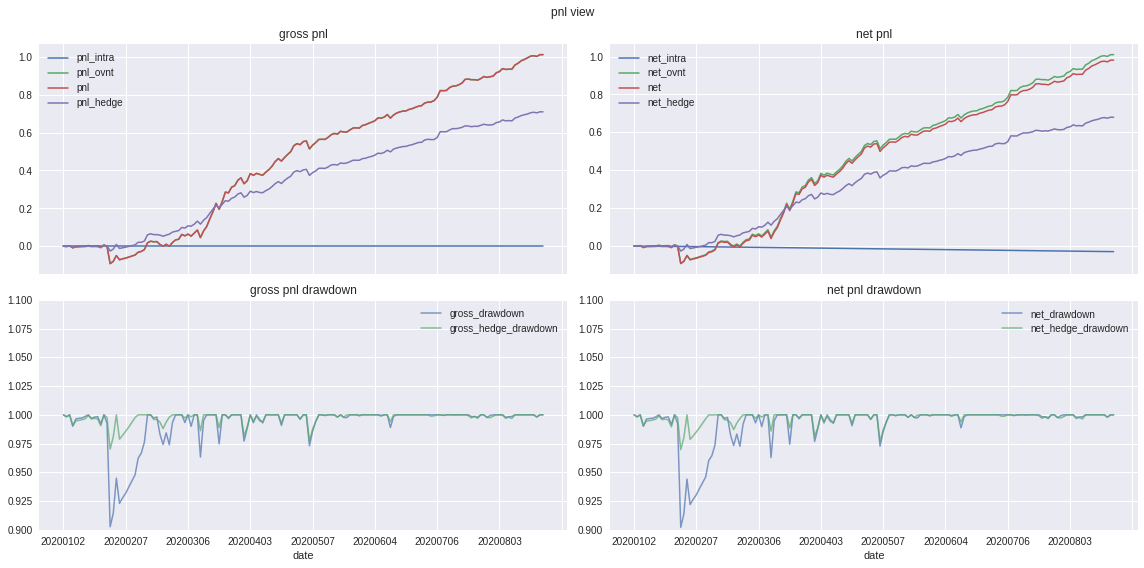

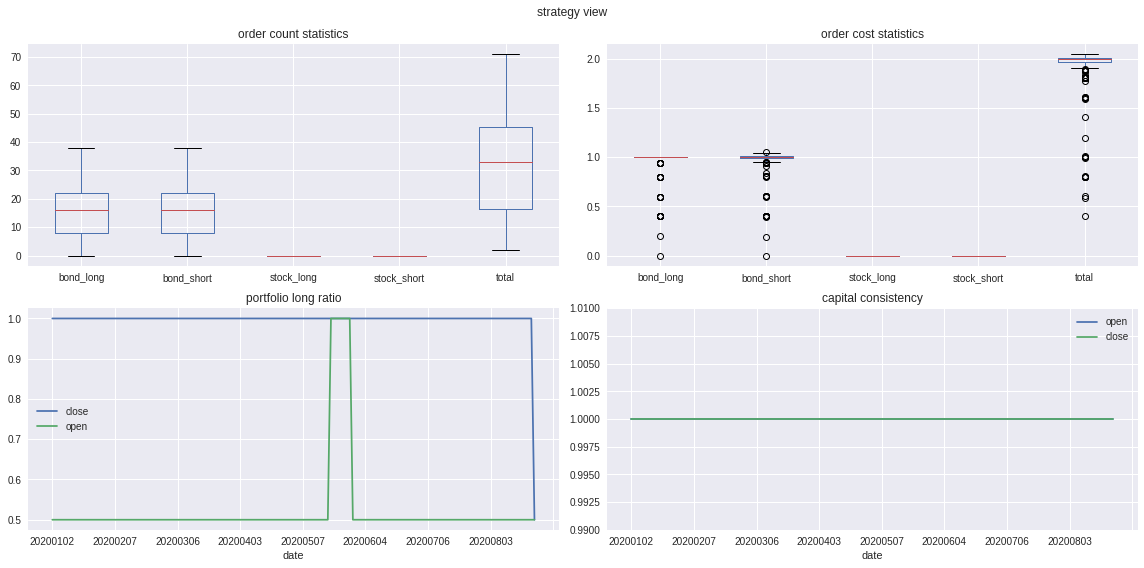

In [20]:
# best random forest model 
backtest_config.start_date='20200101'
CBT = CbondBacktest(backtest_config)
strategy = OvntMLStrategy(CBT, model='rf5_0.01' , pool='top1500')
CBT.pipeline(strategy)
CBT.analysis(strategy, plot=True)

#### 6. Pricing Model Strategy

In [10]:
class PricingStrategy(Strategy):
    '''
    buy convertible bond based on overvalue factors(calculated by pricing model)
    sell them when overvalue reverse to a certain degree, or the holding day reach to the maximum at close
    '''
    def __init__(self, CBT, num=20, para=0, max_win=10, hedge=1, pool='all'):
        Strategy.__init__(self, CBT)
        self.pricing_data = pd.read_csv(os.path.join(self.CBT.data_path, 'pricing.csv'), index_col=False)
        self.pricing_data['date'] = self.pricing_data['date'].astype('str')
        self.pricing_data['all'] = True
        
        self.pool = pool 
        self.max_weight = 0.2
        self.num = num
        self.para = para
        self.max_win = max_win
        self.hedge = hedge
    
    
    # =============== Interaction with Backtest System =================
    def sendOrder(self, date, time='close'):
        if time == 'open':
            pass
        
        else:
            # check holdings
            # sell the stock if have no convertible bond
            for stock_ticker in list(self.CBT.portfolio['stock'].keys()):
                bond_ticker = self.CBT.getStockCbond(stock_ticker, date)
                if bond_ticker not in list(self.CBT.portfolio['bond'].keys()):
                    self.CBT.clearTicker(date, stock_ticker, asset_type='stock', time=time)
        
            # load data
            pricing_data = self.pricing_data[(self.pricing_data['date'] == date) &
                                 (self.pricing_data['{}'.format(self.pool)]==True)].copy()
            
            # hold convertible bond until cum_ov reverse to a certain level or holding period reach to max_win
            for bond_ticker in list(self.CBT.portfolio['bond'].keys()):
                fac_dict = pricing_data.set_index('bond_ticker')['cum_ov'].to_dict()
                
                if bond_ticker in fac_dict.keys():
                    cum_ov = fac_dict[bond_ticker]
                else:
                    cum_ov = self.para['cum_ov'][1]
                    
                if (self.CBT.portfolio['bond'][bond_ticker]['count'] >= self.max_win) or (cum_ov >= self.para['cum_ov'][2]):
                    self.CBT.clearTicker(date, bond_ticker, asset_type='bond', time=time)
                    stock_ticker = self.CBT.getCbondStock(bond_ticker)
                    self.CBT.clearTicker(date, stock_ticker, asset_type='stock', time=time)
                
            # signal
            data = pricing_data[(pricing_data['cum_ov'] <= self.para['cum_ov'][0]) & 
                                (pricing_data['cum_ov'] >= self.para['cum_ov'][1]) &
                                (pricing_data['valid'].isin(self.para['valid'])) &
                                (~pricing_data['bond_ticker'].isin(self.CBT.portfolio['bond'].keys())) &
                                (~pricing_data['stock_ticker'].isin(self.CBT.portfolio['stock'].keys()))].copy()
            
            num = len(data)
            if num == 0:
                return None
            
            data.sort_values(by='cum_ov', ascending=True)
            data = data.iloc[:self.num]
            
            # available cash
            long_cash = self.CBT.cap - self.CBT.getPortfolioLongCost()
            data['weight'] = np.minimum(np.sqrt(data['cum_ov'].abs()) / np.sqrt(data['cum_ov'].abs()).sum(), self.max_weight)
            data['capital'] = data['weight'] * min(self.CBT.cap, long_cash)
            
            data_info = data.to_dict('records')
            
            # order
            for info in data_info:
                bond_ticker = info['bond_ticker']
                bond_price = self.CBT.getPrice(date, bond_ticker, asset_type='bond', time=time)
                bond_capital = info['capital']
                bond_amount = int(bond_capital / bond_price // self.CBT.min_share['bond'] * self.CBT.min_share['bond'])
                
                stock_ticker = info['stock_ticker']
                stock_price = self.CBT.getPrice(date, stock_ticker, asset_type='stock', time=time)
                stock_capital = info['capital'] * self.hedge
                stock_amount = -1 * int(stock_capital / stock_price // self.CBT.min_share['stock'] * self.CBT.min_share['stock'])
                
                if bond_amount != 0:
                    self.CBT.order(date, bond_ticker, bond_amount, asset_type='bond', time=time)
                if stock_amount != 0:
                    self.CBT.order(date, stock_ticker, stock_amount, asset_type='stock', time=time)

== backtest init ==


100%|██████████| 886/886 [00:20<00:00, 42.42it/s]


,total_return,annual_return,annual_volatility,sharpe_ratio,win_rate,max_drawdown
pnl,0.2069,0.0584,0.1561,0.1177,0.6682,-0.1414
pnl_open,1.2622,0.3561,0.0843,3.7498,0.8104,-0.0771
pnl_close,-1.0553,-0.2978,0.1331,-2.5383,0.5858,-1.1268
pnl_trade,0.2069,0.0584,0.1776,0.1035,0.6885,-0.1298
pnl_trans,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000
pnl_intra,-1.0553,-0.2978,0.1331,-2.5383,0.5858,-1.1268
pnl_ovnt,1.2622,0.3561,0.0843,3.7498,0.8104,-0.0771
pnl_hedge,0.1851,0.0522,0.1533,0.0798,0.6625,-0.1351
net,-0.4274,-0.1206,0.1563,-1.0277,0.6230,-0.4978
net_hedge,-0.4492,-0.1267,0.1535,-1.0865,0.6208,-0.5244


,dates,trade_dates,order_sum,order_mean,cover_num,trade_win,conv_win,order_cost,refuse_rate,turnover,port_num,port_value,long_ratio
bond,886,0.6637,11336.0000,19.2789,49,0.5221,0,1.8064,0.0007,149.8526,6.3928,0.5994,0.8310
stock,886,0.6637,11182.0000,19.0170,48,0.4919,0,1.7762,0.0198,147.3452,6.4656,0.6076,0.1690
total,886,0.6637,22518.0000,38.2959,97,0.5071,0,3.5825,0.0103,297.1977,12.8584,1.2070,0.4988


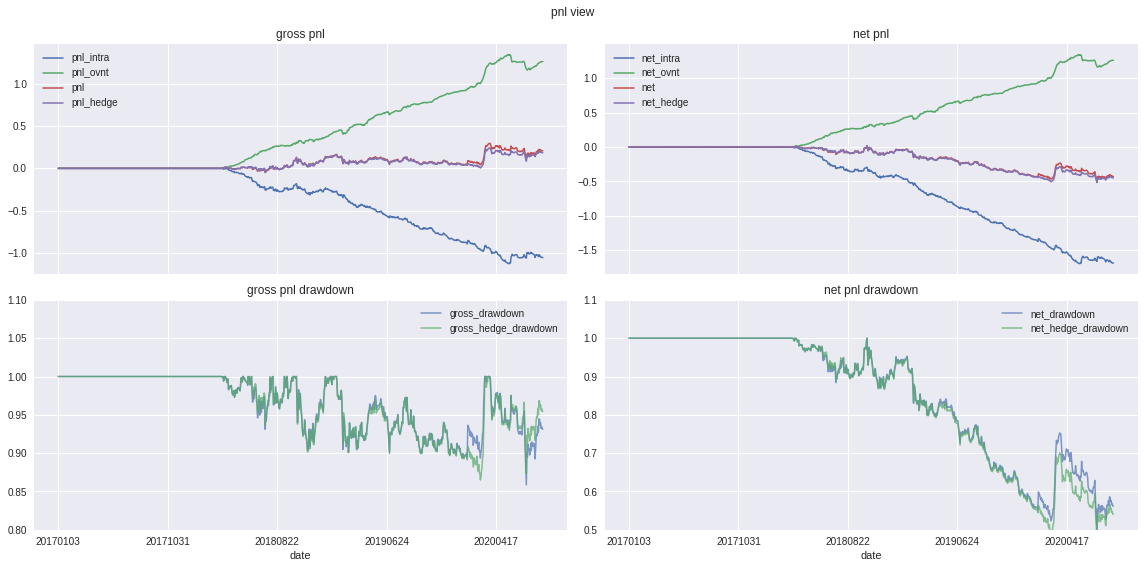

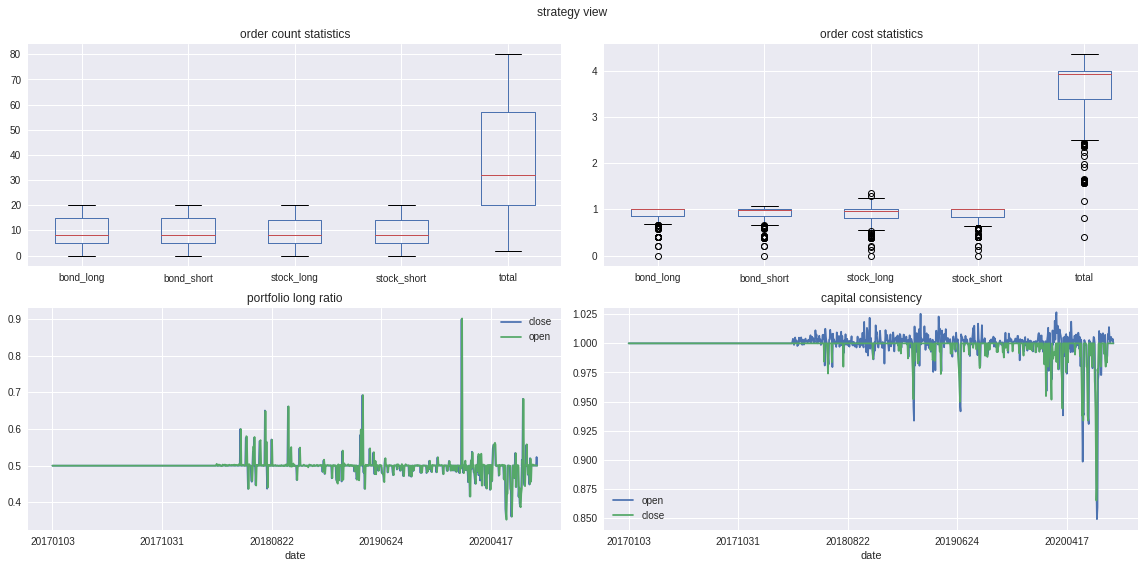

In [14]:
backtest_config.start_date='20170103'
CBT = CbondBacktest(backtest_config)
para = {
    'cum_ov': (-1, -np.inf, -0.5),  # (entry maximum level, entry minimium level, exit level)
    'valid':[True],
}
strategy = PricingStrategy(CBT, num=20, para=para, max_win=1, hedge=1, pool='top1500')
CBT.pipeline(strategy)
CBT.analysis(plot=True)

#### 7. Intraday Strategy

In [5]:
class IntraStrategy(Strategy):
    '''
    buy convertible bond based on intra factors at open
    sell all at close
    '''
    def __init__(self, CBT, para, num=20, hedge=0, pool='all'):
        Strategy.__init__(self, CBT)
        self.pricing_data = pd.read_csv(os.path.join(self.CBT.data_path, 'pricing.csv'), index_col=False)
        self.pricing_data['date'] = self.pricing_data['date'].astype('str')
        self.pricing_data['all'] = True
        
        self.pool = pool 
        self.max_weight = 0.2
        self.num = num
        self.para = para
        self.hedge = hedge
    
    
    # =============== Interaction with Backtest System =================
    def sendOrder(self, date, time='close'):
        if time == 'close':
            self.CBT.clearHolding(date, time)
        
        else:
            prev_date = self.CBT.getPrevDate(date)
            
            # signal
            available_bond_tickers = list(self.CBT.cbond_data[date].keys())
            data = self.pricing_data[(self.pricing_data['date'] == prev_date) &
                                     (self.pricing_data['{}'.format(self.pool)]==True) &
                                     (self.pricing_data['bond_ticker'].isin(available_bond_tickers))].copy()
            
            data = data[(data['intra_fac'] <= self.para['intra']) & 
                        (data['overvalue'] <= self.para['overvalue']) &
                        (data['valid'].isin(self.para['valid']))].copy()

            num = len(data)
            if num == 0:
                return None
            
            data.sort_values(by='intra_fac', ascending=True)
            data = data.iloc[:self.num]
            
            # available cash
            long_cash = self.CBT.cap - self.CBT.getPortfolioLongCost()
            data['weight'] = np.minimum(data['intra_fac'].abs() / data['intra_fac'].abs().sum(), self.max_weight)
            data['capital'] = data['weight'] * long_cash
            
            data_info = data.to_dict('records')
            
            # order
            for info in data_info:
                bond_ticker = info['bond_ticker']
                bond_price = self.CBT.getPrice(date, bond_ticker, asset_type='bond', time=time)
                bond_capital = info['capital']
                bond_amount = int(bond_capital / bond_price // self.CBT.min_share['bond'] * self.CBT.min_share['bond'])
                
                stock_ticker = info['stock_ticker']
                stock_price = self.CBT.getPrice(date, stock_ticker, asset_type='stock', time=time)
                stock_capital = info['capital'] * self.hedge
                stock_amount = -1 * int(stock_capital / stock_price // self.CBT.min_share['stock'] * self.CBT.min_share['stock'])
                
                if bond_amount != 0:
                    self.CBT.order(date, bond_ticker, bond_amount, asset_type='bond', time=time)
                if stock_amount != 0:
                    self.CBT.order(date, stock_ticker, stock_amount, asset_type='stock', time=time)
#                 print('order {} {} {}'.format(date, bond_ticker, stock_ticker))

== backtest init ==


100%|██████████| 886/886 [00:14<00:00, 62.91it/s]


,total_return,annual_return,annual_volatility,sharpe_ratio,win_rate,max_drawdown
pnl,1.5692,0.4428,0.1207,3.3381,0.6716,-0.0577
pnl_open,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000
pnl_close,1.5692,0.4428,0.1207,3.3381,0.6716,-0.0577
pnl_trade,1.5692,0.4428,0.1207,3.3381,0.6716,-0.0577
pnl_trans,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000
pnl_intra,1.5692,0.4428,0.1207,3.3381,0.6716,-0.0577
pnl_ovnt,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000
pnl_hedge,1.1893,0.3356,0.0689,4.2884,0.6840,-0.0249
net,1.4432,0.4072,0.1205,3.0483,0.6603,-0.0619
net_hedge,1.0633,0.3000,0.0687,3.7835,0.6637,-0.0256


,dates,trade_dates,order_sum,order_mean,cover_num,trade_win,conv_win,order_cost,refuse_rate,turnover,port_num,port_value,long_ratio
bond,886,0.8533,13300,17.5926,207,0.5826,0,1.6668,0.0017,177.7771,3.7528,0.3551,0.7133
stock,886,0.8533,0,0.0000,0,0.0000,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.5000
total,886,0.8533,13300,17.5926,207,0.5826,0,1.6668,0.0017,177.7771,3.7528,0.3551,0.7133


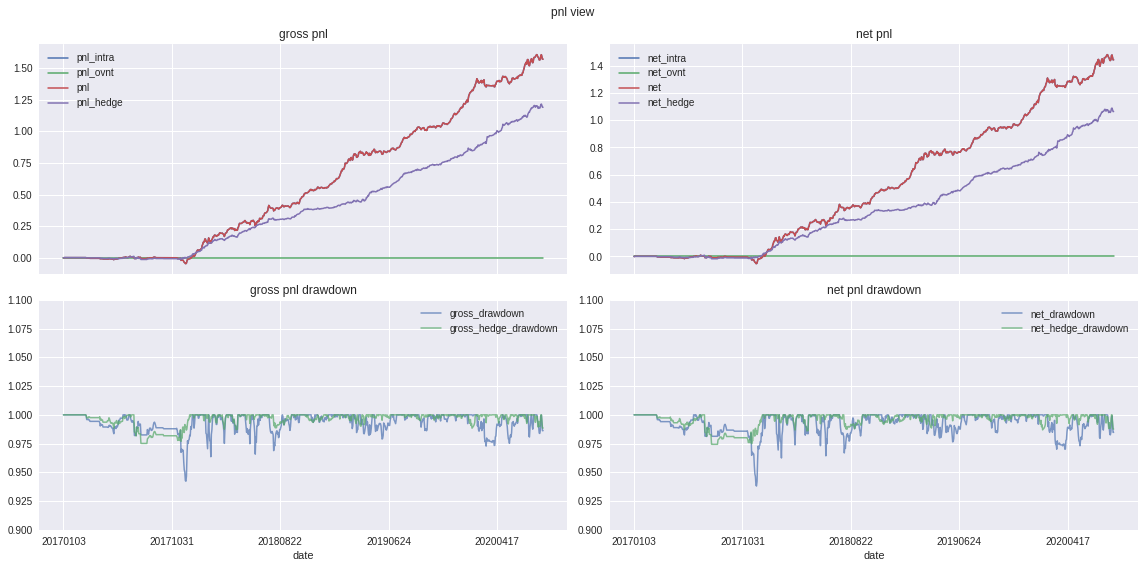

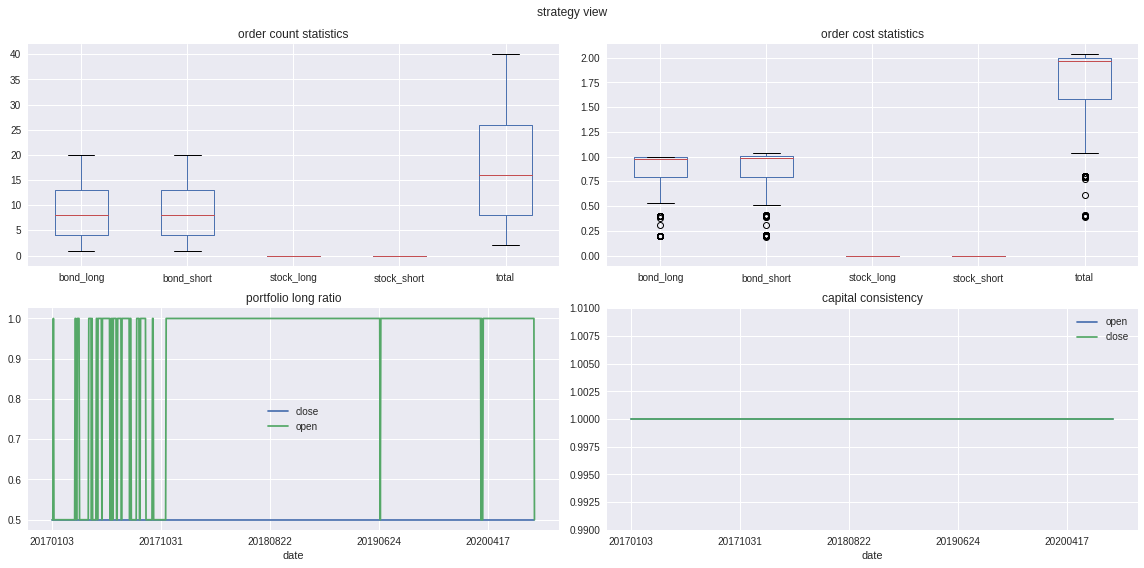

In [10]:
backtest_config.start_date='20170103'
CBT = CbondBacktest(backtest_config)
para = {
    'intra': -0.002,
    'overvalue': 0.1,
    'valid':[True],
}
strategy = IntraStrategy(CBT, para=para, num=20, hedge=0, pool='top1500')
CBT.pipeline(strategy)
CBT.analysis(plot=True)